# Glauber on infinite random $k$-regular graph
Explore the effects of tilting the distribution by adding an external field at final time
$$
\phi_i^T(x_i^T) \propto \exp\{-\beta h^T\}
$$

In [1]:
using MatrixProductBP, MatrixProductBP.Models
using Plots
using ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using JLD2;

In [114]:
include("../../telegram/notifications.jl");

In [2]:
T = 20         # final time
k = 3          # degree
m⁰ = 0.5       # magnetization at time zero

J = 0.6;

In [113]:
function glauber_rrg(T, k, m⁰, J, h, h_final; 
        β=1.0, showprogress=true, matrix_sizes = [5, 10, 25], tol=1e-3)
    wᵢ = fill(HomogeneousGlauberFactor(J, h, β), T+1)
    ϕᵢ = map(0:T) do t
        if t == 0 
            [(1+m⁰)/2, (1-m⁰)/2]
        elseif t == T
            [exp(β*h_final), exp(-β*h_final)]
        else
            ones(2)
        end
    end
    bp = mpbp_infinite_graph(k, wᵢ, 2, ϕᵢ)
    cb = CB_BP(bp; showprogress)
    
    
    maxiters = fill(100, length(matrix_sizes))
    iters = zeros(Int, length(maxiters))
    for i in eachindex(maxiters)
        iters[i], _ = iterate!(bp; maxiter=maxiters[i], svd_trunc=TruncBond(matrix_sizes[i]), cb, tol)
    end
    
    iters_cum = cumsum(iters)
    inds = 1:iters_cum[1]
    pl_convergence = plot(inds, cb.Δs[inds], label="$(matrix_sizes[1])x$(matrix_sizes[1]) matrices")
    for i in 2:length(iters)
        inds = iters_cum[i-1]:iters_cum[i]
       plot!(pl_convergence, inds, cb.Δs[inds], label="$(matrix_sizes[i])x$(matrix_sizes[i]) matrices")
    end
    plot!(pl_convergence, ylabel="convergence error", xlabel="iters", yaxis=:log10, size=(300,200))
    
    spin(x, i) = 3-2x
    m = only(means(spin, bp))
    
    pl_convergence, m, only(bp.f)
end;

### 1. Free dynamics

In [17]:
h = 0.0
h_final = 0.0
pl_convergence_free, magnetiz_free, f_free = glauber_rrg(T, k, m⁰, J, h, h_final);

Running MPBP: iter 33 	 Time: 0:11:48
  Δ:  0.000776284299607183

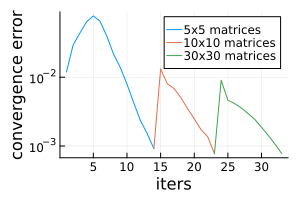

In [18]:
plot(pl_convergence_free)

In [19]:
f_free

-0.0004795011455058784

### 2. Tilt with external field at final fime

In [46]:
h = 0.0
h_final = 1.0
pl_convergence_tilted, magnetiz_tilted, f_tilted = glauber_rrg(T, k, m⁰, J, h, h_final);

Running MPBP: iter 21 	 Time: 0:02:47
  Δ:                0.0005564120501351138
  SVD Matrix size:  25

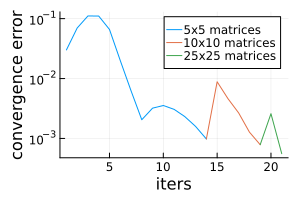

In [47]:
plot(pl_convergence_tilted)

### 3. Free dynamics ending at the same magnetization as the tilted one

In [22]:
h = 0.7
h_final = 0.0
pl_convergence_free2, magnetiz_free2, f_free2 = glauber_rrg(T, k, m⁰, J, h, h_final);

Running MPBP: iter 7 	 Time: 0:00:04
  Δ:            3.938186877899554e-5
  Matrix size:  30

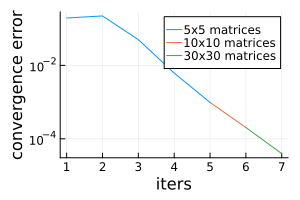

In [23]:
plot(pl_convergence_free2)

Compare

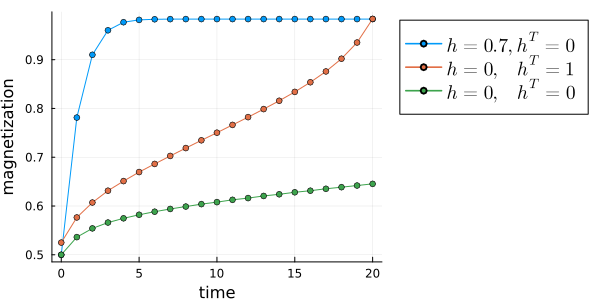

In [48]:
pl = plot(xlabel="time", ylabel="magnetization", label="", size=(600,300), xticks=0:5:T, 
    legend=:outertopright, legendfontsize=13)
plot!(pl, 0:T, magnetiz_free2, m=:o, label="\$h=0.7,  h^T=0\$", ms=3)
plot!(pl, 0:T, magnetiz_tilted, m=:o, label="\$h=0, \\quad  h^T=1\$", ms=3)
plot!(pl, 0:T, magnetiz_free, m=:o, label="\$h=0, \\quad  h^T=0\$", ms=3)

In [218]:
jldsave("plot_data/glauber_tilted.jld2"; T, magnetiz_free2, magnetiz_free, magnetiz_tilted);

## Large deviations

In [116]:
T = 20         # final time
k = 3          # degree
m⁰ = 0.1       # magnetization at time zero

β = 1.0
J = 0.6
h = 0.0;

In [ ]:
hs = (-0.05:0.0025:0.03)
fs = zeros(length(hs))
magnetizs = [zeros(T+1) for _ in hs]
ms = zeros(length(hs))
pls = [plot() for _ in hs]
matrix_sizes = [5, 12, 25]

@telegram "glauber final time" begin
    Threads.@threads for i in eachindex(hs)
        h_final = hs[i]
        pls[i], magnetizs[i], fs[i] = glauber_rrg(T, k, m⁰, J, h, h_final; 
            showprogress=true, matrix_sizes, tol=1e-5)
        ms[i] = magnetizs[i][end]
    end
end

Running MPBP: iter 100 	 Time: 0:10:14
  Δ:                5.8349930225333136e-5
  SVD Matrix size:  12

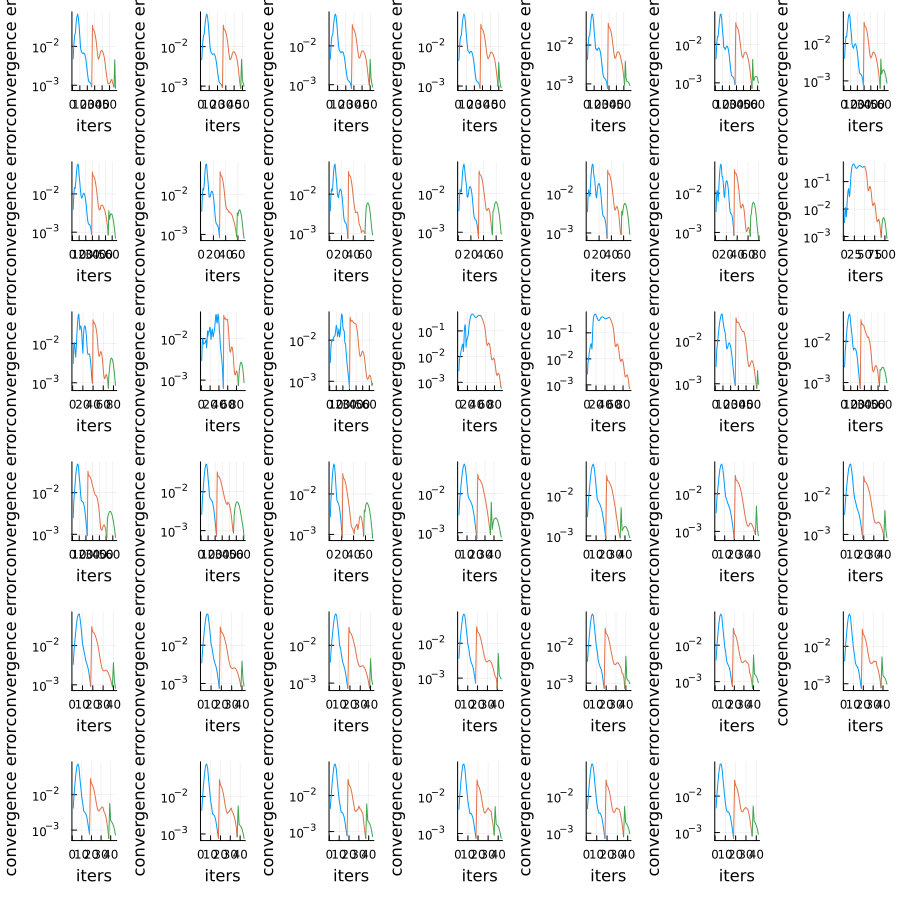

In [69]:
plot(pls..., size=(900,900), legend=false)

In [126]:
using ColorSchemes
cg = cgrad(:matter, length(hs), categorical=true) .|> RGB

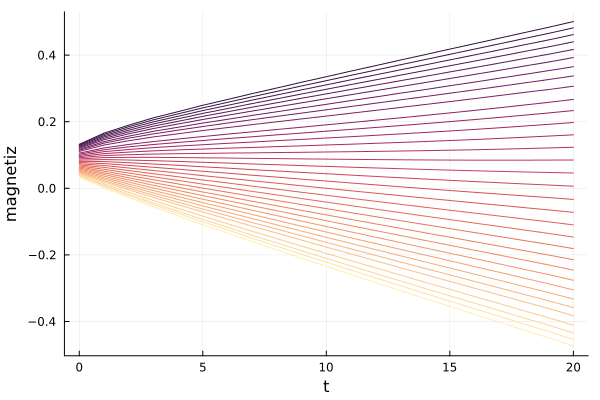

In [138]:
pl = plot(xlabel="t", ylabel="magnetiz", zcolor=hs)
for i in reverse(eachindex(hs))
    plot!(pl, 0:T, magnetizs[i], c=cg[i], label="h=$(hs[i])")
end
plot!(pl, legend=false)
# plot(pl, legend=:outertopright)


In [134]:
pl1 = scatter(hs, ms, label="", xlabel="h", ylabel="m");
# scatter!(pl1, [-0.015], [-0.07226460726316164]);
# scatter!(pl1, [-0.015], [-0.04280966917950868]);

In [135]:
pl2 = scatter(hs, fs, label="", xlabel="h", ylabel="f");
# scatter!(pl2, [-0.015], [0.0017107139299170626]);
# scatter!(pl2, [-0.015], [-0.001759422778750519]);

In [136]:
gs = hs.*ms .+ fs
pl4 = scatter(ms, gs, label="", xlabel="m", ylabel="g", #xlims=(-1,1),
    c=cg, zcolor=hs, colorbar_title=" \nh");
# scatter!(pl4, [-0.04280966917950868], [-0.001759422778750519 + hs[18]*-0.04280966917950868])

L"$f(h)=-\frac1N\log\sum_\sigma w(\sigma)e^{h\sum_i\sigma_i^T}=\min_m\{g(m)-mh\},\quad g(m)=\min_h\{f(h)+mh\}$"

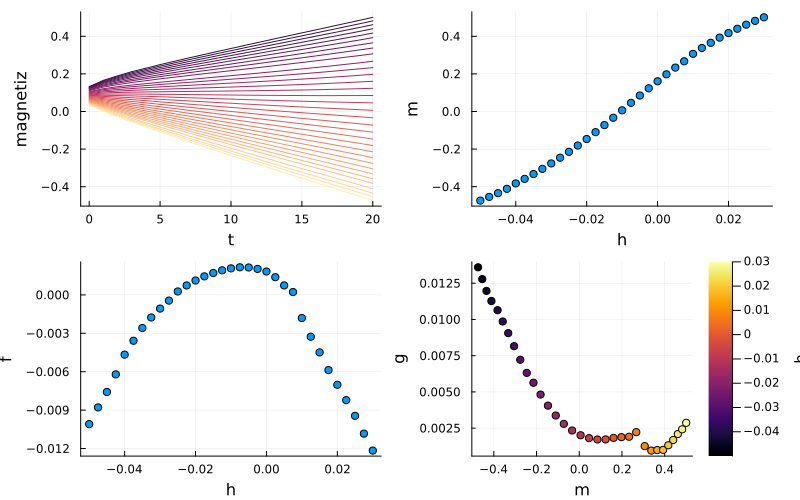

In [139]:
using LaTeXStrings
st = L"f(h)=-\frac1N\log\sum_\sigma w(\sigma)e^{h\sum_i\sigma_i^T}=\min_m\{g(m)-mh\},\quad g(m)=\min_h\{f(h)+mh\}"
display(st)
plot(pl, pl1, pl2, pl4, layout=(2,2), size=(800,500))

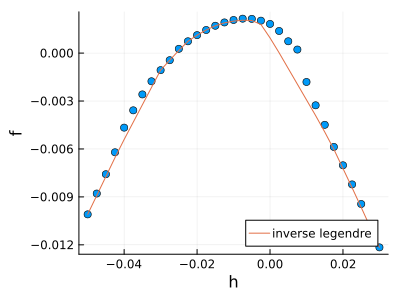

In [143]:
ff = zeros(length(hs))
for i in eachindex(hs)
   ff[i] = minimum(gs[j]-ms[j]*hs[i] for j in eachindex(hs)) 
end
plot!(deepcopy(pl2), hs, ff, label="inverse legendre", size=(400,300), legend=:bottomright)